In [37]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

from scipy import interpolate
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

import matplotlib.colors as colors
import matplotlib
# Pick font here
# matplotlib.rcParams['font.serif'] = "Times"
# Then set this font globally
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.size'] = 7.5
matplotlib.rcParams['xtick.major.width'] = 1.6
matplotlib.rcParams['xtick.minor.size'] = 4.0
matplotlib.rcParams['xtick.minor.width'] = 1.2

matplotlib.rcParams['ytick.major.size'] = 7.5
matplotlib.rcParams['ytick.major.width'] = 1.6
matplotlib.rcParams['ytick.minor.size'] = 4.0
matplotlib.rcParams['ytick.minor.width'] = 1.2

In [2]:
filename = "/global/project/projectdirs/lz/users/abiekert/lz_photoneutron_studies/sr1_skim_files/20220421_skim/YBe_SS_ROI_FV_events_cuts.root"
content = uproot.open(filename)

events = content['Events;1']
scatters = content['Scatters;1']

s1c = scatters['ss./ss.correctedS1Area_phd'].array().to_numpy()
s2raw = scatters['ss./ss.s2Area_phd'].array().to_numpy()
s2c = scatters['ss./ss.correctedS2Area_phd'].array().to_numpy()

x_raw = scatters['ss./ss.x_cm'].array().to_numpy()
y_raw = scatters['ss./ss.y_cm'].array().to_numpy()
drift_time = scatters['ss./ss.driftTime_ns'].array().to_numpy()/1e3

max_drift = 900
lz_height = 145.6

drift_z = (max_drift-drift_time)*lz_height/max_drift
r2 = x_raw*x_raw + y_raw*y_raw

x_corr = scatters['ss./ss.correctedX_cm'].array().to_numpy()
y_corr = scatters['ss./ss.correctedY_cm'].array().to_numpy()
z_corr = scatters['ss./ss.correctedZ_cm'].array().to_numpy()

r2_corr = x_corr*x_corr + y_corr*y_corr

s1_TBA = scatters['ss./ss.s1TBA'].array().to_numpy()

s2_top_area =  scatters['ss./ss.s2TopArea_phd'].array().to_numpy()
s2_bottom_area =  scatters['ss./ss.s2BottomArea_phd'].array().to_numpy()
s2_TBA = (s2_top_area - s2_bottom_area) / (s2_top_area + s2_bottom_area)

s1_TBA = scatters['ss./ss.s1TBA'].array().to_numpy()
s2_ID = scatters['ss./ss.s2PulseID'].array().to_numpy()
pulse_rms_width = events['pulsesTPCHG./pulsesTPCHG.rmsWidth_ns'].array()/1e3
pulse_AFT01 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime1_ns'].array()
pulse_AFT05 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime5_ns'].array()
pulse_AFT10 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime10_ns'].array()
pulse_AFT25 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime25_ns'].array()
pulse_AFT50 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime50_ns'].array()
pulse_AFT75 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime75_ns'].array()
pulse_AFT90 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime90_ns'].array()
pulse_AFT95 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime95_ns'].array()
pulse_AFT99 = events['pulsesTPCHG./pulsesTPCHG.areaFractionTime99_ns'].array()

s2_rms_width = np.array([pulse_rms_width[i, pulseID] for i, pulseID in enumerate(s2_ID)])

s2_AFT01 = np.array([pulse_AFT01[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT05 = np.array([pulse_AFT05[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT10 = np.array([pulse_AFT10[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT25 = np.array([pulse_AFT25[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT50 = np.array([pulse_AFT50[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT75 = np.array([pulse_AFT75[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT90 = np.array([pulse_AFT90[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT95 = np.array([pulse_AFT95[i, pulseID] for i, pulseID in enumerate(s2_ID)])
s2_AFT99 = np.array([pulse_AFT99[i, pulseID] for i, pulseID in enumerate(s2_ID)])

s2_width_1005 = s2_AFT10 - s2_AFT05
s2_width_5025 = s2_AFT50 - s2_AFT25
s2_width_7550 = s2_AFT75 - s2_AFT50
s2_width_2510 = s2_AFT25 - s2_AFT10
s2_width_7525 = s2_AFT75 - s2_AFT25

nPulses = events['pulsesTPC./pulsesTPC.nPulses'].array().to_numpy()
event_total_area = events['tpcEventRQs./tpcEventRQs.totalArea_phd'].array().to_numpy()

runID = events['eventHeader./eventHeader.runID'].array().to_numpy()
eventID = events['eventHeader./eventHeader.eventID'].array().to_numpy()

In [3]:
# default g1, g2 values for 9 kV
def get_iso_energy_contour(Er,g1=0.108, g2=58.183815, option="NR"):
    """
    get energy contours for S1,logS2 plots
    """
    # g1 = [phd/photon], g2 = [phd/electron]
    # Ne + Np = E/W
    if(option == "ER"):
        W = 0.0136 #keV/quanta
        L = 1 # Lindhard factor, 1 for ERs
        Ntot = L*Er/W
    else:
        Ntot = 11 * (Er**1.1)
    Ne = np.linspace(0.1,Ntot,200)
    Np = Ntot - Ne
    S1 = Np * g1
    S2 = Ne * g2
    return S1, np.log10(S2)

def get_reconstructed_energy(S1c, S2c, g1=0.108, g2=58.183815, option="NR"):
    if option == "ER":
        W = 0.0136 #keV/quanta
        energy = W*(S1c/g1 + S2c/g2)
    elif option == "NR":
        a = 11.43
        b = 1.068
        energy = ((S1c/g1 + S2c/g2)/a)**(1/b)
    elif option == "NRs2O":
        # Nest 2.2.3 average from 1-5 keVnr
        charge_yield = 7.055340248022983
        energy = S2c/g2/charge_yield
    else:
        energy = 0
    return energy
        

# A new beginning

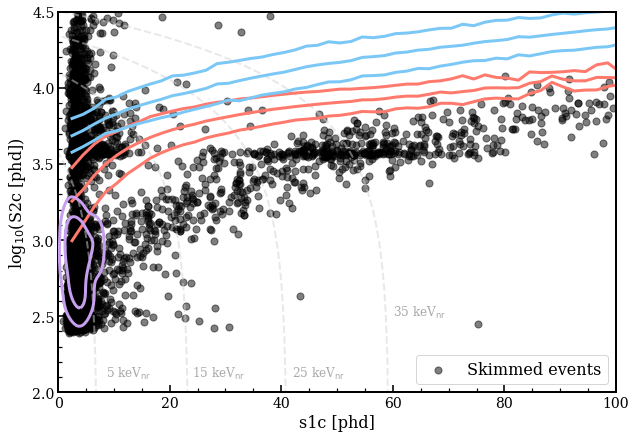

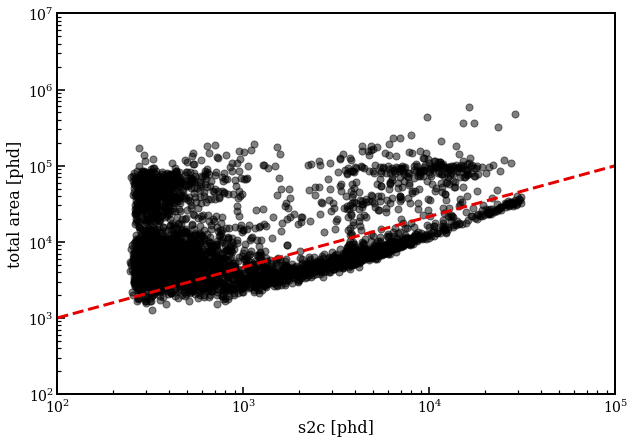

In [20]:
band_file_nr = '/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v1/AmLi_Band_logS2_skew_band.txt'
band_values_nr = np.loadtxt(band_file_nr, skiprows=1, usecols=[0,1,2,3], converters={2: lambda s: s.split(b'[')[1], 3: lambda s: s.split(b']')[0]})

band_file_er = '/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/v1/ERweighted_flatBand_logS2_skew_band.txt'
band_values_er = np.loadtxt(band_file_er, skiprows=1, usecols=[0,1,2,3], converters={2: lambda s: s.split(b'[')[1], 3: lambda s: s.split(b']')[0]})

filename = '/global/homes/b/biekerta/photoneutron_analysis/ALPACA/run/CalibYBe/YBeSR1SimsAnalysis_SKCustom.root'
file = uproot.open(filename)

#s1c_all, logS2c_all = file['SV_LogS2vS1;S1c [phd];Log(S2c [phd]);1'].values()
s1c_ss_fid, logS2c_ss_fid = file['SS_ROI_Fid_LogS2vS1_TGraph;S1c [phd];Log(S2c [phd]);1'].values()

# for later
pn_sv_nv_hist, bin_edges = file["PN_SV_NV_EnergyZoom_truth;Energy [keV]"].to_numpy()
bin_centers_nv = (bin_edges[:-1] + bin_edges[1:])/2
binsize = bin_centers_nv[1] - bin_centers_nv[0]
pn_sv_nv_hist = pn_sv_nv_hist / binsize / 1e7

counts,xbins,ybins=np.histogram2d(s1c_ss_fid,logS2c_ss_fid,bins=100, range=[[0,30],[2.0, 4.5]])

counts = counts / np.sum(counts)

sigma = 3.0 # this depends on how noisy your data is, play with it!
counts = gaussian_filter(counts, sigma)

n = 100
t = np.linspace(0, counts.max(), n)
integral = ((counts >= t[:, None, None]) * counts).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.95, 0.68]))

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

# plot iso-energy contours:
E_to_plot = [ 5, 15, 25, 35 ] 
txt_x = [ 8.5, 24, 42, 60 ]
txt_y = [ 2.1, 2.1, 2.1, 2.5 ]
for i,E in enumerate(E_to_plot):
    s1, logs2 = get_iso_energy_contour(E)
    plt.plot(s1, logs2, color='lightgrey', linestyle='--', alpha=0.5, lw=2)
    txt = r'{:.0f} '.format(E) + r'keV$_{\rm nr}$'
    plt.text(txt_x[i], txt_y[i], txt, fontsize=12, color='darkgrey', zorder=1)

cuts_roi = ((s1c < 100) & (np.log10(s2c) < 4.5))
cuts = cuts_roi
    
ax.scatter(s1c[cuts], np.log10(s2c[cuts]), color='xkcd:black', s=50, alpha=0.5, label='Skimmed events')

plt.contour(counts.T, t_contours, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], colors=['xkcd:lavender'], linewidths=3, zorder=5)

ax.plot(band_values_nr[:,0], band_values_nr[:,1], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]-band_values_nr[:,2], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]+band_values_nr[:,3], color='xkcd:salmon', linestyle='-', linewidth=3)

ax.plot(band_values_er[:,0], band_values_er[:,1], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]-band_values_er[:,2], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]+band_values_er[:,3], color='xkcd:lightblue', linestyle='-', linewidth=3)

ax.set_xlabel(r's1c [phd]', fontsize=16)
ax.set_ylabel('log$_{10}$(S2c [phd])', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([2.0, 4.5])

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
ax.plot([1e2, 1e5], [1e3, 1e5], linewidth=3, color='xkcd:red', linestyle='--')
ax.scatter(s2c[cuts], event_total_area[cuts], color='xkcd:black', s=50, label="SS", alpha=0.5)

ax.set_xlabel(r's2c [phd]', fontsize=16)
ax.set_ylabel('total area [phd]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([100, 1e5])
ax.set_ylim([100, 1e7])

ax.semilogx()
ax.semilogy()

plt.show()


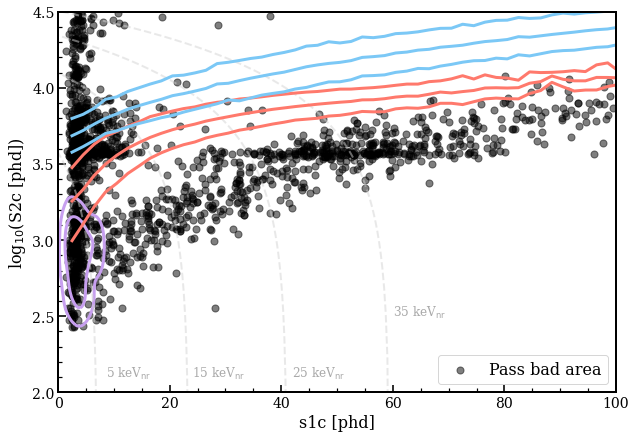

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

# plot iso-energy contours:
E_to_plot = [ 5, 15, 25, 35 ] 
txt_x = [ 8.5, 24, 42, 60 ]
txt_y = [ 2.1, 2.1, 2.1, 2.5 ]
for i,E in enumerate(E_to_plot):
    s1, logs2 = get_iso_energy_contour(E)
    plt.plot(s1, logs2, color='lightgrey', linestyle='--', alpha=0.5, lw=2)
    txt = r'{:.0f} '.format(E) + r'keV$_{\rm nr}$'
    plt.text(txt_x[i], txt_y[i], txt, fontsize=12, color='darkgrey', zorder=1)

bad_area_coefficients = np.polyfit([np.log10(1e2), np.log10(1e5)], [np.log10(1e3), np.log10(1e5)], 1)
bad_area_cut = (event_total_area < 10**np.poly1d(bad_area_coefficients)(np.log10(s2c)))
    
ax.scatter(s1c[cuts & bad_area_cut], np.log10(s2c)[cuts & bad_area_cut], color='xkcd:black', s=50, alpha=0.5, label='Pass bad area')
#ax.scatter(s1c[cuts & ~bad_area_cut], np.log10(s2c)[cuts & ~bad_area_cut], color='xkcd:red', s=50, alpha=0.5, label='Fail bad area')

plt.contour(counts.T, t_contours, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], colors=['xkcd:lavender'], linewidths=3)

ax.plot(band_values_nr[:,0], band_values_nr[:,1], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]-band_values_nr[:,2], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]+band_values_nr[:,3], color='xkcd:salmon', linestyle='-', linewidth=3)

ax.plot(band_values_er[:,0], band_values_er[:,1], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]-band_values_er[:,2], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]+band_values_er[:,3], color='xkcd:lightblue', linestyle='-', linewidth=3)

ax.set_xlabel(r's1c [phd]', fontsize=16)
ax.set_ylabel('log$_{10}$(S2c [phd])', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([2.0, 4.5])

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.png", bbox_inches='tight')

plt.show()


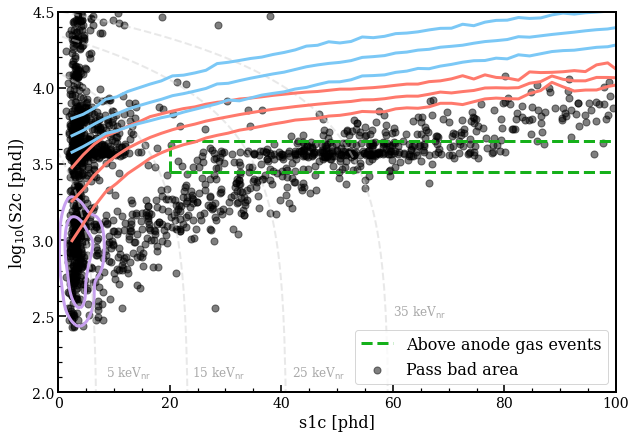

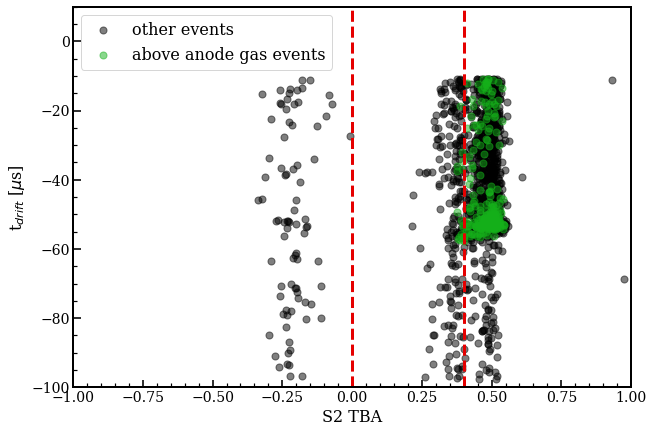

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

# plot iso-energy contours:
E_to_plot = [ 5, 15, 25, 35 ] 
txt_x = [ 8.5, 24, 42, 60 ]
txt_y = [ 2.1, 2.1, 2.1, 2.5 ]
for i,E in enumerate(E_to_plot):
    s1, logs2 = get_iso_energy_contour(E)
    plt.plot(s1, logs2, color='lightgrey', linestyle='--', alpha=0.5, lw=2)
    txt = r'{:.0f} '.format(E) + r'keV$_{\rm nr}$'
    plt.text(txt_x[i], txt_y[i], txt, fontsize=12, color='darkgrey', zorder=1)


s1c_min = 20
logS2c_min = 3.45
logS2c_max = 3.65
    
s1c_cut = (s1c > s1c_min)
logS2c_cut = (np.log10(s2c) > logS2c_min) & (np.log10(s2c) < logS2c_max)
aag_cut = s1c_cut & logS2c_cut

cuts = cuts & bad_area_cut

ax.scatter(s1c[cuts], np.log10(s2c)[cuts], color='xkcd:black', s=50, alpha=0.5, label='Pass bad area')

plt.contour(counts.T, t_contours, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], colors=['xkcd:lavender'], linewidths=3)

ax.plot([s1c_min, 200], [logS2c_max, logS2c_max], linewidth=3, color='xkcd:green', linestyle='--', label='Above anode gas events')
ax.plot([s1c_min, 200], [logS2c_min, logS2c_min], linewidth=3, color='xkcd:green', linestyle='--')
ax.plot([s1c_min, s1c_min], [logS2c_min, logS2c_max], linewidth=3, color='xkcd:green', linestyle='--')

ax.plot(band_values_nr[:,0], band_values_nr[:,1], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]-band_values_nr[:,2], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]+band_values_nr[:,3], color='xkcd:salmon', linestyle='-', linewidth=3)

ax.plot(band_values_er[:,0], band_values_er[:,1], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]-band_values_er[:,2], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]+band_values_er[:,3], color='xkcd:lightblue', linestyle='-', linewidth=3)

ax.set_xlabel(r's1c [phd]', fontsize=16)
ax.set_ylabel('log$_{10}$(S2c [phd])', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([2.0, 4.5])

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_LogS2vS1_BadArea.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

#h, xedges, yedges, im = ax.hist2d(r2_corr[cuts & region_5 & region_6], z_corr[cuts & region_5 & region_6], bins=(x_bin_edges, y_bin_edges), norm=colors.LogNorm())

ax.scatter(s2_TBA[cuts & ~aag_cut], -drift_time[cuts & ~aag_cut], color='xkcd:black', s=50, label="other events", alpha=0.5)
ax.scatter(s2_TBA[cuts & aag_cut], -drift_time[cuts & aag_cut], color='xkcd:green', s=50, label="above anode gas events", alpha=0.5)

ax.plot([0.4, 0.4], [-100, 10], color='xkcd:red', linestyle='--', linewidth=3)
ax.plot([0.0, 0.0], [-100, 10], color='xkcd:red', linestyle='--', linewidth=3)

ax.set_xlabel('S2 TBA', fontsize=16)
ax.set_ylabel('t$_{drift}$ [$\mu$s]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([-1, 1])
ax.set_ylim([-100, 10])

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)  

#cb = ax.figure.colorbar(im, ax=ax)
#cb.set_label(r'counts', fontsize=18)
#cb.ax.tick_params(labelsize=18)

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_PW_TDriftvS2TBA_comparison.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_PW_TDriftvS2TBA_comparison.png", bbox_inches='tight')

plt.show()

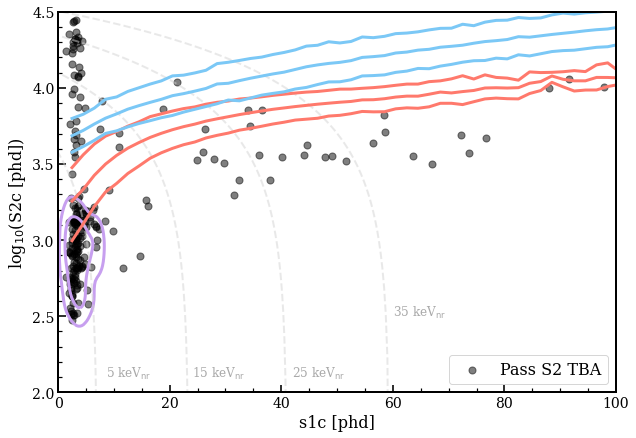

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

# plot iso-energy contours:
E_to_plot = [ 5, 15, 25, 35 ] 
txt_x = [ 8.5, 24, 42, 60 ]
txt_y = [ 2.1, 2.1, 2.1, 2.5 ]
for i,E in enumerate(E_to_plot):
    s1, logs2 = get_iso_energy_contour(E)
    plt.plot(s1, logs2, color='lightgrey', linestyle='--', alpha=0.5, lw=2)
    txt = r'{:.0f} '.format(E) + r'keV$_{\rm nr}$'
    plt.text(txt_x[i], txt_y[i], txt, fontsize=12, color='darkgrey', zorder=1)

tba_cut = (s2_TBA < 0.4) & (s2_TBA > 0.0)

#np.savetxt("sub0_S2TBA.txt", np.vstack([runID[cuts_region_6 & (s2_TBA < 0.0)], eventID[cuts_region_6 & (s2_TBA < 0.0)]]).T, fmt='%10.0f', header="RunID   EventID")
#np.savetxt("sub0_S2TBA_s1gt10.txt", np.vstack([runID[cuts_region_6 & (s2_TBA < 0.0) & (s1c > 10)], eventID[cuts_region_6 & (s2_TBA < 0.0) & (s1c > 10)]]).T, fmt='%10.0f', header="RunID   EventID")
#np.savetxt("good_S2TBA_s1gt10_s1lt20.txt", np.vstack([runID[cuts_region_6 & tba_cut & (s1c > 10) & (s1c < 20)], eventID[cuts_region_6 & tba_cut & (s1c > 10) & (s1c < 20)]]).T, fmt='%10.0f', header="RunID   EventID")

ax.scatter(s1c[cuts & tba_cut], np.log10(s2c)[cuts & tba_cut], color='xkcd:black', s=50, alpha=0.5, label='Pass S2 TBA')
#ax.scatter(s1c[cuts & ~tba_cut], np.log10(s2c)[cuts & ~tba_cut], color='xkcd:red', s=50, alpha=0.5, label='Fail S2 TBA')

plt.contour(counts.T, t_contours, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], colors=['xkcd:lavender'], linewidths=3)

ax.plot(band_values_nr[:,0], band_values_nr[:,1], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]-band_values_nr[:,2], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]+band_values_nr[:,3], color='xkcd:salmon', linestyle='-', linewidth=3)

ax.plot(band_values_er[:,0], band_values_er[:,1], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]-band_values_er[:,2], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]+band_values_er[:,3], color='xkcd:lightblue', linestyle='-', linewidth=3)

ax.set_xlabel(r's1c [phd]', fontsize=16)
ax.set_ylabel('log$_{10}$(S2c [phd])', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([2.0, 4.5])

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

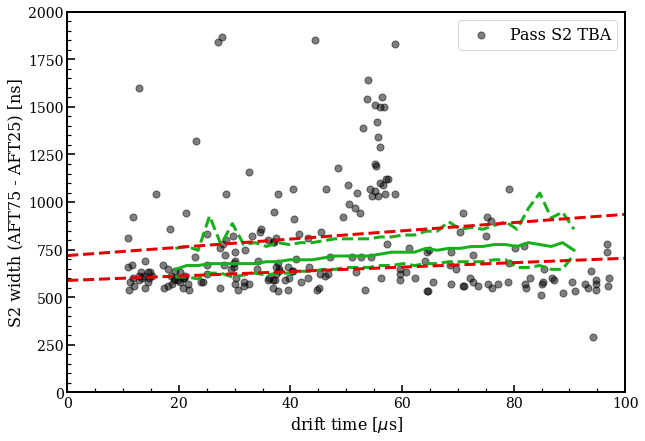

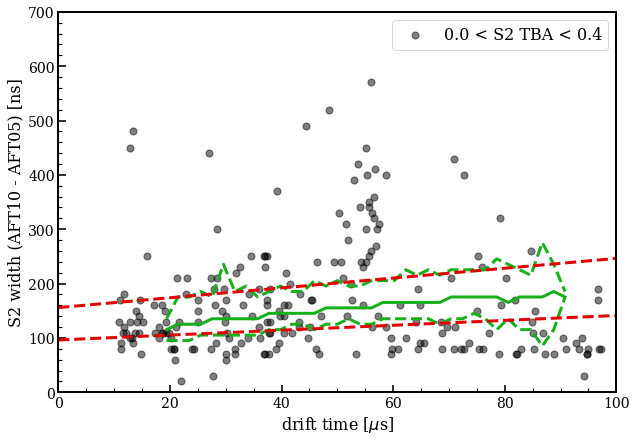

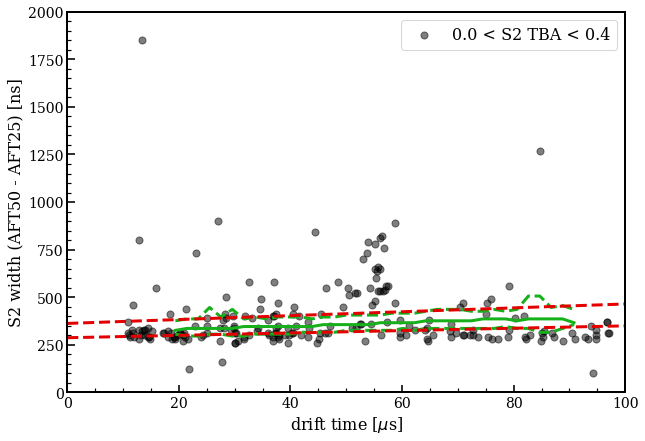

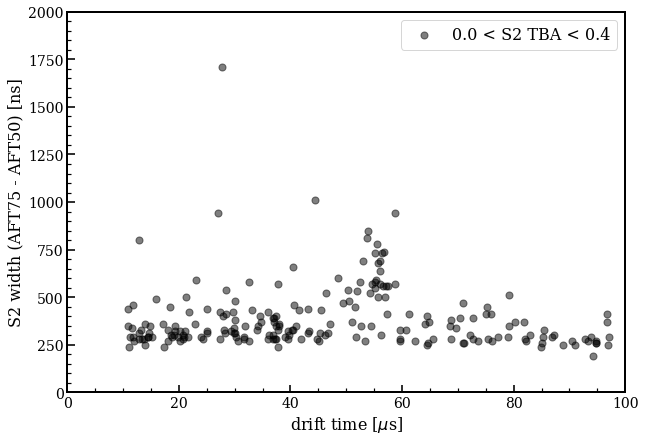

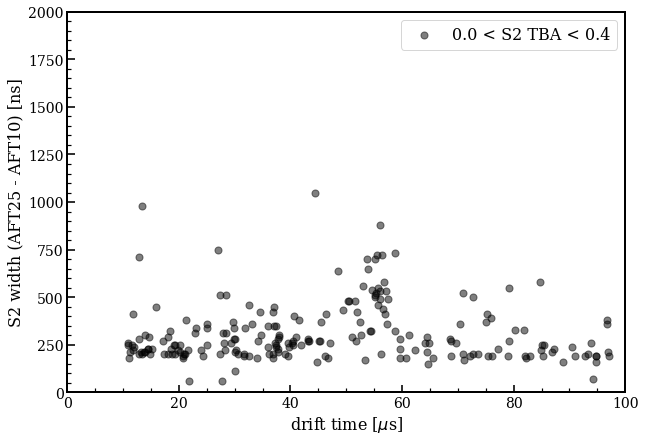

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

cuts = cuts & tba_cut

ax.scatter(drift_time[cuts], s2_width_7525[cuts], color='xkcd:black', s=50, alpha=0.5, label='Pass S2 TBA')

drift_bands = np.loadtxt("/global/homes/b/biekerta/s1_lrf_analysis/notebooks/AFT7525_drift_bands.txt")

ax.plot(drift_bands[:,0], drift_bands[:,1], linewidth=3, color='xkcd:green')
ax.plot(drift_bands[:,0], drift_bands[:,2], linewidth=3, color='xkcd:green', linestyle='--')
ax.plot(drift_bands[:,0], drift_bands[:,3], linewidth=3, color='xkcd:green', linestyle='--')

#ax.plot([0, 100], [900, 900], color='xkcd:red', linestyle='--', linewidth=3)
#ax.plot([0, 100], [600, 600], color='xkcd:red', linestyle='--', linewidth=3)

lower_band_fit_7525 = np.polyfit(drift_bands[:,0], drift_bands[:,2], 1)
upper_band_fit_7525 = np.polyfit(drift_bands[:,0], drift_bands[:,3], 1)

x_vals = np.linspace(0, 100, num=100)

ax.plot(x_vals, np.polyval(lower_band_fit_7525, x_vals), linewidth=3, linestyle='--', color='xkcd:red')
ax.plot(x_vals, np.polyval(upper_band_fit_7525, x_vals), linewidth=3, linestyle='--', color='xkcd:red')

ax.set_xlabel(r'drift time [$\mu$s]', fontsize=16)
ax.set_ylabel('S2 width (AFT75 - AFT25) [ns]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([0, 2000])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

ax.scatter(drift_time[cuts], s2_width_1005[cuts], color='xkcd:black', s=50, alpha=0.5, label='0.0 < S2 TBA < 0.4')

drift_bands = np.loadtxt("/global/homes/b/biekerta/s1_lrf_analysis/notebooks/AFT1005_drift_bands.txt")

ax.plot(drift_bands[:,0], drift_bands[:,1], linewidth=3, color='xkcd:green')
ax.plot(drift_bands[:,0], drift_bands[:,2], linewidth=3, color='xkcd:green', linestyle='--')
ax.plot(drift_bands[:,0], drift_bands[:,3], linewidth=3, color='xkcd:green', linestyle='--')

lower_band_fit_1005 = np.polyfit(drift_bands[:,0], drift_bands[:,2], 1)
upper_band_fit_1005 = np.polyfit(drift_bands[:,0], drift_bands[:,3], 1)

x_vals = np.linspace(0, 100, num=100)

ax.plot(x_vals, np.polyval(lower_band_fit_1005, x_vals), linewidth=3, linestyle='--', color='xkcd:red')
ax.plot(x_vals, np.polyval(upper_band_fit_1005, x_vals), linewidth=3, linestyle='--', color='xkcd:red')

ax.set_xlabel(r'drift time [$\mu$s]', fontsize=16)
ax.set_ylabel('S2 width (AFT10 - AFT05) [ns]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([0, 700])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

ax.scatter(drift_time[cuts], s2_width_5025[cuts], color='xkcd:black', s=50, alpha=0.5, label='0.0 < S2 TBA < 0.4')

drift_bands = np.loadtxt("/global/homes/b/biekerta/s1_lrf_analysis/notebooks/AFT5025_drift_bands.txt")

ax.plot(drift_bands[:,0], drift_bands[:,1], linewidth=3, color='xkcd:green')
ax.plot(drift_bands[:,0], drift_bands[:,2], linewidth=3, color='xkcd:green', linestyle='--')
ax.plot(drift_bands[:,0], drift_bands[:,3], linewidth=3, color='xkcd:green', linestyle='--')

lower_band_fit_5025 = np.polyfit(drift_bands[:,0], drift_bands[:,2], 1)
upper_band_fit_5025 = np.polyfit(drift_bands[:,0], drift_bands[:,3], 1)

x_vals = np.linspace(0, 100, num=100)

ax.plot(x_vals, np.polyval(lower_band_fit_5025, x_vals), linewidth=3, linestyle='--', color='xkcd:red')
ax.plot(x_vals, np.polyval(upper_band_fit_5025, x_vals), linewidth=3, linestyle='--', color='xkcd:red')

ax.set_xlabel(r'drift time [$\mu$s]', fontsize=16)
ax.set_ylabel('S2 width (AFT50 - AFT25) [ns]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([0, 2000])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

ax.scatter(drift_time[cuts], s2_width_7550[cuts], color='xkcd:black', s=50, alpha=0.5, label='0.0 < S2 TBA < 0.4')

ax.set_xlabel(r'drift time [$\mu$s]', fontsize=16)
ax.set_ylabel('S2 width (AFT75 - AFT50) [ns]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([0, 2000])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

############################

fig, ax = plt.subplots(1, 1, figsize=(10,7))

ax.scatter(drift_time[cuts], s2_width_2510[cuts], color='xkcd:black', s=50, alpha=0.5, label='0.0 < S2 TBA < 0.4')

ax.set_xlabel(r'drift time [$\mu$s]', fontsize=16)
ax.set_ylabel('S2 width (AFT25 - AFT10) [ns]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([0, 2000])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

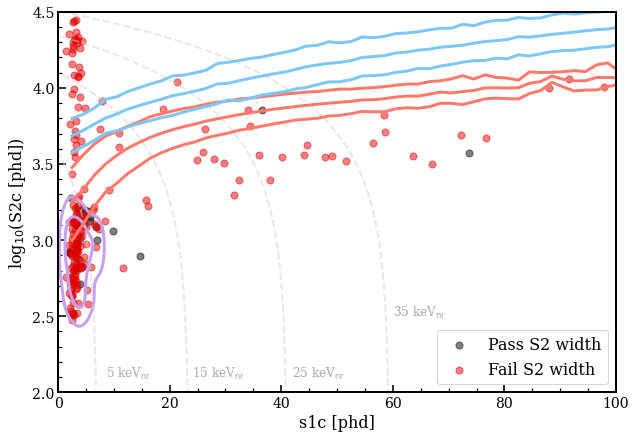

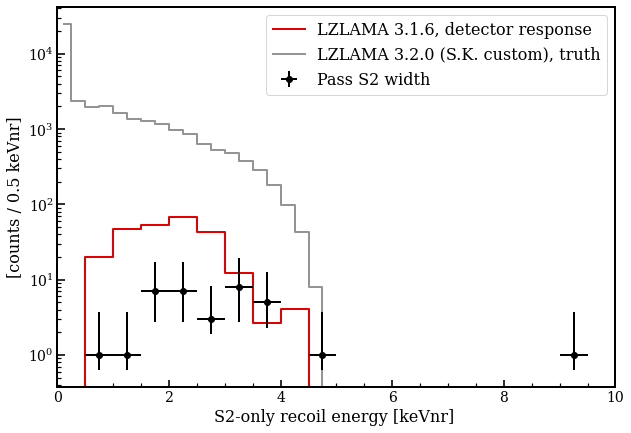

35 events
249.55510745088 sim reconstructed events


In [47]:
##
# Error bar helpers -- taken from J. Aalbers multihist https://github.com/JelleAalbers/multihist/blob/master/multihist.py
##

# Zero-background 1 sigma Poisson Feldman-Cousins intervals
# From table II in https://arxiv.org/pdf/physics/9711021.pdf
_fc_intervals = np.array([
    [0.0, 1.29],
    [0.37, 2.75],
    [0.74, 4.25],
    [1.1, 5.3],
    [2.34, 6.78],
    [2.75, 7.81],
    [3.82, 9.28],
    [4.25, 10.3],
    [5.3, 11.32],
    [6.44, 12.79],
    [6.78, 13.81],
    [7.81, 14.82],
    [8.83, 16.29],
    [9.28, 17.3],
    [10.3, 18.32],
    [11.32, 19.32],
    [12.33, 20.8],
    [12.79, 21.81],
    [13.81, 22.82],
    [14.82, 23.82],
    [15.83, 25.3]])


def poisson_central_interval(k, cl=0.6826894921370859):
    """Return central Poisson confidence interval
    :param k: observed events
    :param cl: confidence level
    """
    # Adapted from https://stackoverflow.com/a/14832525
    k = np.asarray(k).astype(int)
    alpha = 1 - cl
    low = stats.chi2.ppf(alpha / 2, 2 * k) / 2
    high = stats.chi2.ppf(1 - alpha / 2, 2 * k + 2) / 2
    return np.stack([np.nan_to_num(low), high])


def poisson_1s_interval(k, fc=True):
    """Return (low, high) 1 sigma Poisson confidence intervals
    :param k: Observed events (int or array of ints)
    :param fc: if True (default), use Feldman-Cousins for k <= 20,
    and central intervals otherwise.
    (at k = 20, the difference between these is 1-2%).
    """
    k = np.asarray(k).astype(int)
    result = poisson_central_interval(k)
    if fc:
        mask = k <= 20
        result[:, mask] = _fc_intervals[k[mask]].T
    return result

fig, ax = plt.subplots(1, 1, figsize=(10,7))

# plot iso-energy contours:
E_to_plot = [ 5, 15, 25, 35 ] 
txt_x = [ 8.5, 24, 42, 60 ]
txt_y = [ 2.1, 2.1, 2.1, 2.5 ]
for i,E in enumerate(E_to_plot):
    s1, logs2 = get_iso_energy_contour(E)
    plt.plot(s1, logs2, color='lightgrey', linestyle='--', alpha=0.5, lw=2)
    txt = r'{:.0f} '.format(E) + r'keV$_{\rm nr}$'
    plt.text(txt_x[i], txt_y[i], txt, fontsize=12, color='darkgrey', zorder=1)

#s2_width_cut = (s2_width_5025 < 1000) & (s2_width_1005 < 800)
s2_width_cut_7525 = (s2_width_7525 < np.polyval(upper_band_fit_7525, drift_time)) & (s2_width_7525 > np.polyval(lower_band_fit_7525, drift_time))
s2_width_cut_1005 = (s2_width_1005 < np.polyval(upper_band_fit_1005, drift_time)) & (s2_width_1005 > np.polyval(lower_band_fit_1005, drift_time))
s2_width_cut_5025 = (s2_width_5025 < np.polyval(upper_band_fit_5025, drift_time)) & (s2_width_5025 > np.polyval(lower_band_fit_5025, drift_time))
s2_width_cut = s2_width_cut_1005 & s2_width_cut_5025 & s2_width_cut_7525

ax.scatter(s1c[cuts & s2_width_cut], np.log10(s2c)[cuts & s2_width_cut], color='xkcd:black', s=50, alpha=0.5, label='Pass S2 width')
ax.scatter(s1c[cuts & ~s2_width_cut], np.log10(s2c)[cuts & ~s2_width_cut], color='xkcd:red', s=50, alpha=0.5, label='Fail S2 width')

np.savetxt("220422-candidate_events.txt", np.vstack([runID[cuts & s2_width_cut], eventID[cuts & s2_width_cut]]).T, fmt='%10.0f', header="RunID   EventID")
np.savetxt("220422-fail_s2width.txt", np.vstack([runID[cuts & ~s2_width_cut], eventID[cuts & ~s2_width_cut]]).T, fmt='%10.0f', header="RunID   EventID")

plt.contour(counts.T, t_contours, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], colors=['xkcd:lavender'], linewidths=3)

ax.plot(band_values_nr[:,0], band_values_nr[:,1], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]-band_values_nr[:,2], color='xkcd:salmon', linestyle='-', linewidth=3)
ax.plot(band_values_nr[:,0], band_values_nr[:,1]+band_values_nr[:,3], color='xkcd:salmon', linestyle='-', linewidth=3)

ax.plot(band_values_er[:,0], band_values_er[:,1], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]-band_values_er[:,2], color='xkcd:lightblue', linestyle='-', linewidth=3)
ax.plot(band_values_er[:,0], band_values_er[:,1]+band_values_er[:,3], color='xkcd:lightblue', linestyle='-', linewidth=3)

ax.set_xlabel(r's1c [phd]', fontsize=16)
ax.set_ylabel('log$_{10}$(S2c [phd])', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.set_xlim([0, 100])
ax.set_ylim([2.0, 4.5])

ax.legend(fontsize=16)

#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.pdf", bbox_inches='tight')
#fig.savefig("alpaca_plots/SS_ROI_FV_PW_LogS2vS1_TBA.png", bbox_inches='tight')

plt.show()

############################

bin_min = 0
bin_max = 25
num_bins = 50
bins = np.linspace(bin_min, bin_max, num=num_bins, endpoint=False)

reco_energy_hist, bin_edges = np.histogram(get_reconstructed_energy(s1c[cuts & s2_width_cut], s2c[cuts & s2_width_cut], option="NRs2O"), bins)
reco_energy_hist_sim, _ = np.histogram(get_reconstructed_energy(s1c_ss_fid, 10**logS2c_ss_fid, option="NRs2O"), bins)

reco_energy_hist_sim = reco_energy_hist_sim*(1.14e6 * 1.07e-4 * 0.992 * 60 * 60 * 30.8)/1e7

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
binsize = bin_centers[1] - bin_centers[0]

fig, ax = plt.subplots(1, 1, figsize=(10,7))
  
ax.errorbar(bin_centers[reco_energy_hist>0], reco_energy_hist[reco_energy_hist>0], xerr=binsize/2, yerr=poisson_1s_interval(reco_energy_hist[reco_energy_hist>0]), marker='o', elinewidth=2, linestyle='none', color='xkcd:black', label='Pass S2 width', zorder=3)
ax.plot(bin_centers, reco_energy_hist_sim, drawstyle='steps-mid', linewidth=2, color='xkcd:red', label='LZLAMA 3.1.6, detector response')
ax.plot(bin_centers_nv, pn_sv_nv_hist*(1.14e6 * 1.07e-4 * 0.992 * 60 * 60 * 30.8)/2, drawstyle='steps-mid', linewidth=2, color='xkcd:grey', label='LZLAMA 3.2.0 (S.K. custom), truth')

ax.set_xlim([0, 10])
#ax.set_ylim([5e-4, 1e-1])

ax.semilogy()

ax.set_xlabel(r'S2-only recoil energy [keVnr] ', fontsize=16)
ax.set_ylabel('[counts / 0.5 keVnr]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.legend(fontsize=16)

plt.show()

print(np.sum(reco_energy_hist), "events")
print(np.sum(reco_energy_hist_sim), "sim reconstructed events")

In [33]:
(1.14e6 * 1.07e-4 * 0.992 * 60 * 60 * 30.8)/1e7

1.34169412608

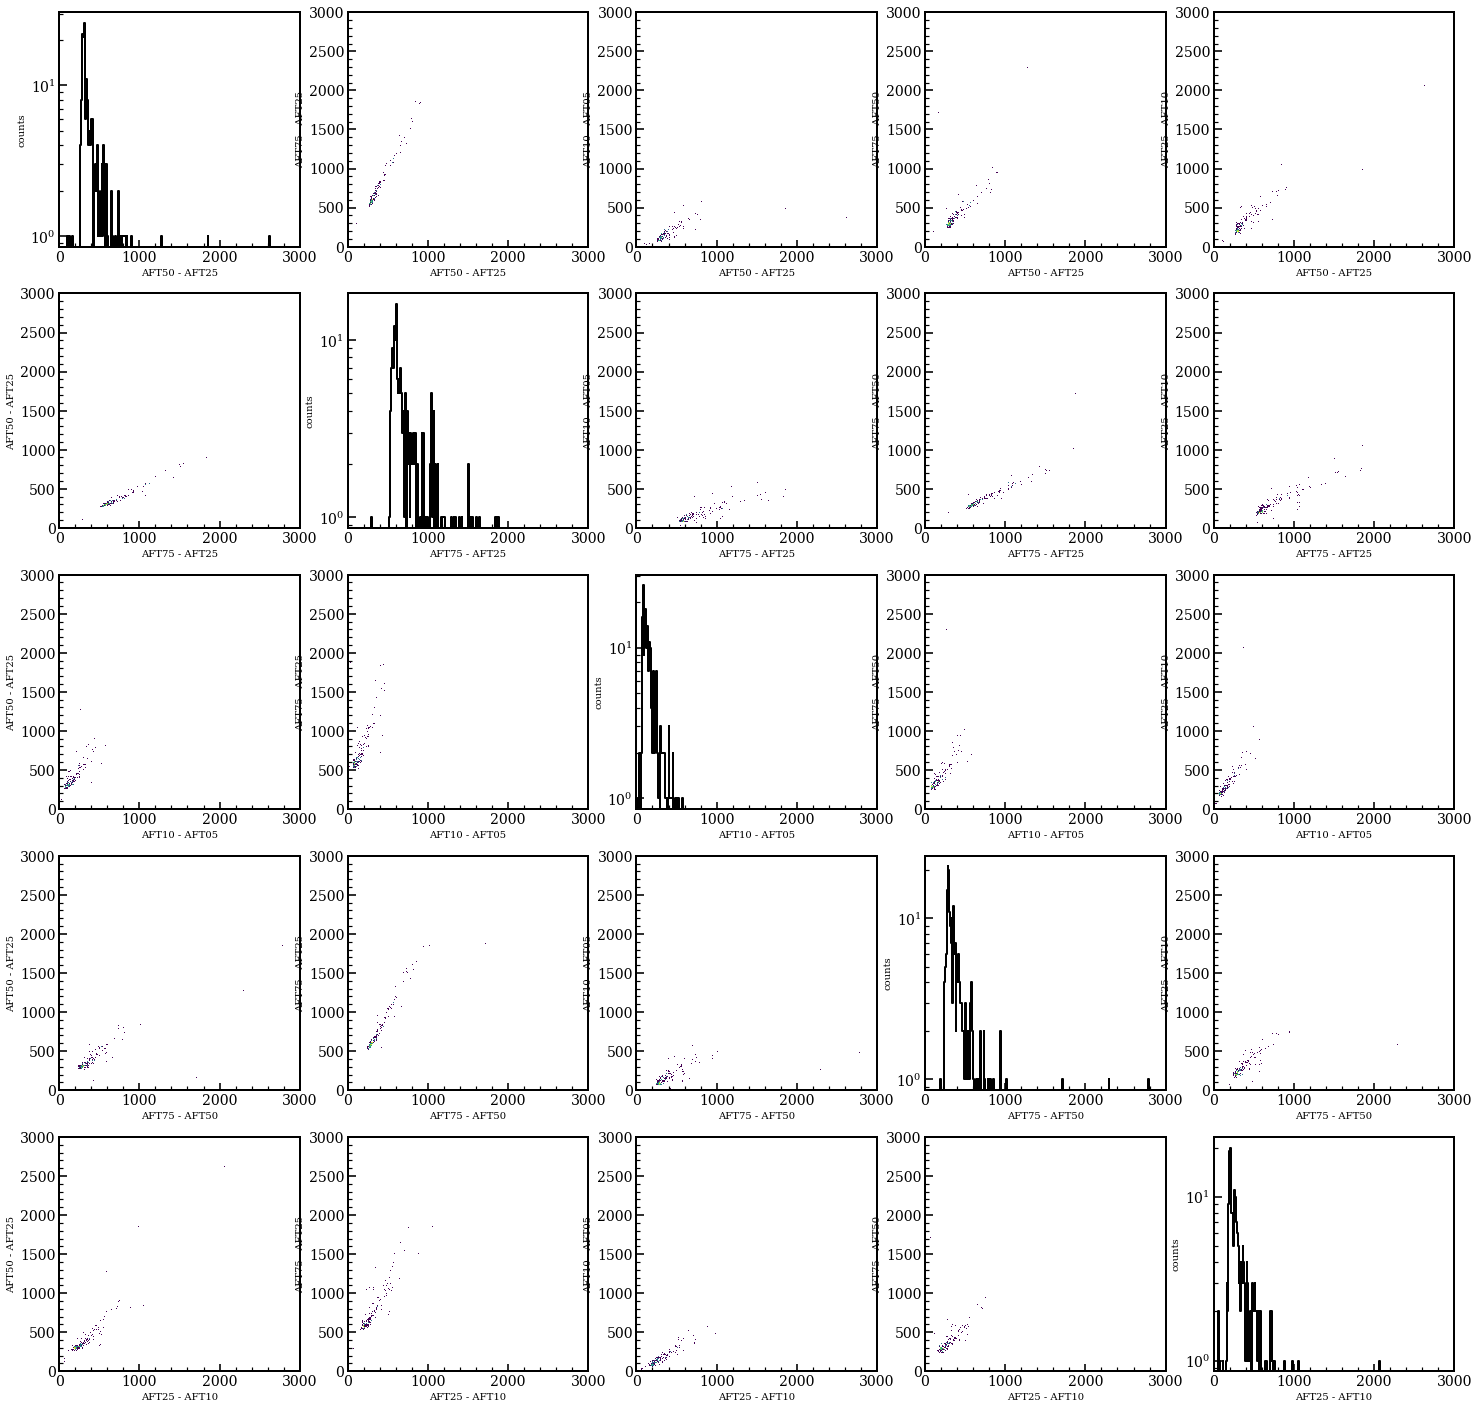

In [10]:
s2_widths = {'AFT50 - AFT25' : s2_width_5025[cuts],
             'AFT75 - AFT25' : s2_width_7525[cuts],
             'AFT10 - AFT05' : s2_width_1005[cuts],
             'AFT75 - AFT50' : s2_width_7550[cuts],
             'AFT25 - AFT10' : s2_width_2510[cuts]}

xbins = np.linspace(0, 5000, num=500, endpoint=False)
ybins = np.linspace(0, 5000, num=500, endpoint=False)

fig, ax = plt.subplots(len(s2_widths), len(s2_widths), figsize=(25, 25))

for i, s2_width_i in enumerate(s2_widths):
    for j, s2_width_j in enumerate(s2_widths):
        if i == j:
            hist, bin_edges = np.histogram(s2_widths[s2_width_i], xbins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            ax[i,j].plot(bin_centers, hist, drawstyle='steps-mid', linewidth=2, color='xkcd:black')
            ax[i,j].set_xlabel(s2_width_i)
            ax[i,j].set_ylabel('counts')
            ax[i,j].tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
            ax[i,j].minorticks_on()
            
            ax[i,j].semilogy()
            ax[i,j].set_xlim([0, 3000])

        else:
            
            h, xedges, yedges, im = ax[i,j].hist2d(s2_widths[s2_width_i], s2_widths[s2_width_j], bins=(xbins, ybins), norm=matplotlib.colors.LogNorm())
            ax[i,j].set_xlabel(s2_width_i)
            ax[i,j].set_ylabel(s2_width_j)
            ax[i,j].tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
            ax[i,j].minorticks_on()
            
            ax[i,j].set_xlim([0, 3000])
            ax[i,j].set_ylim([0, 3000])

plt.savefig("s2_width_grid.png")

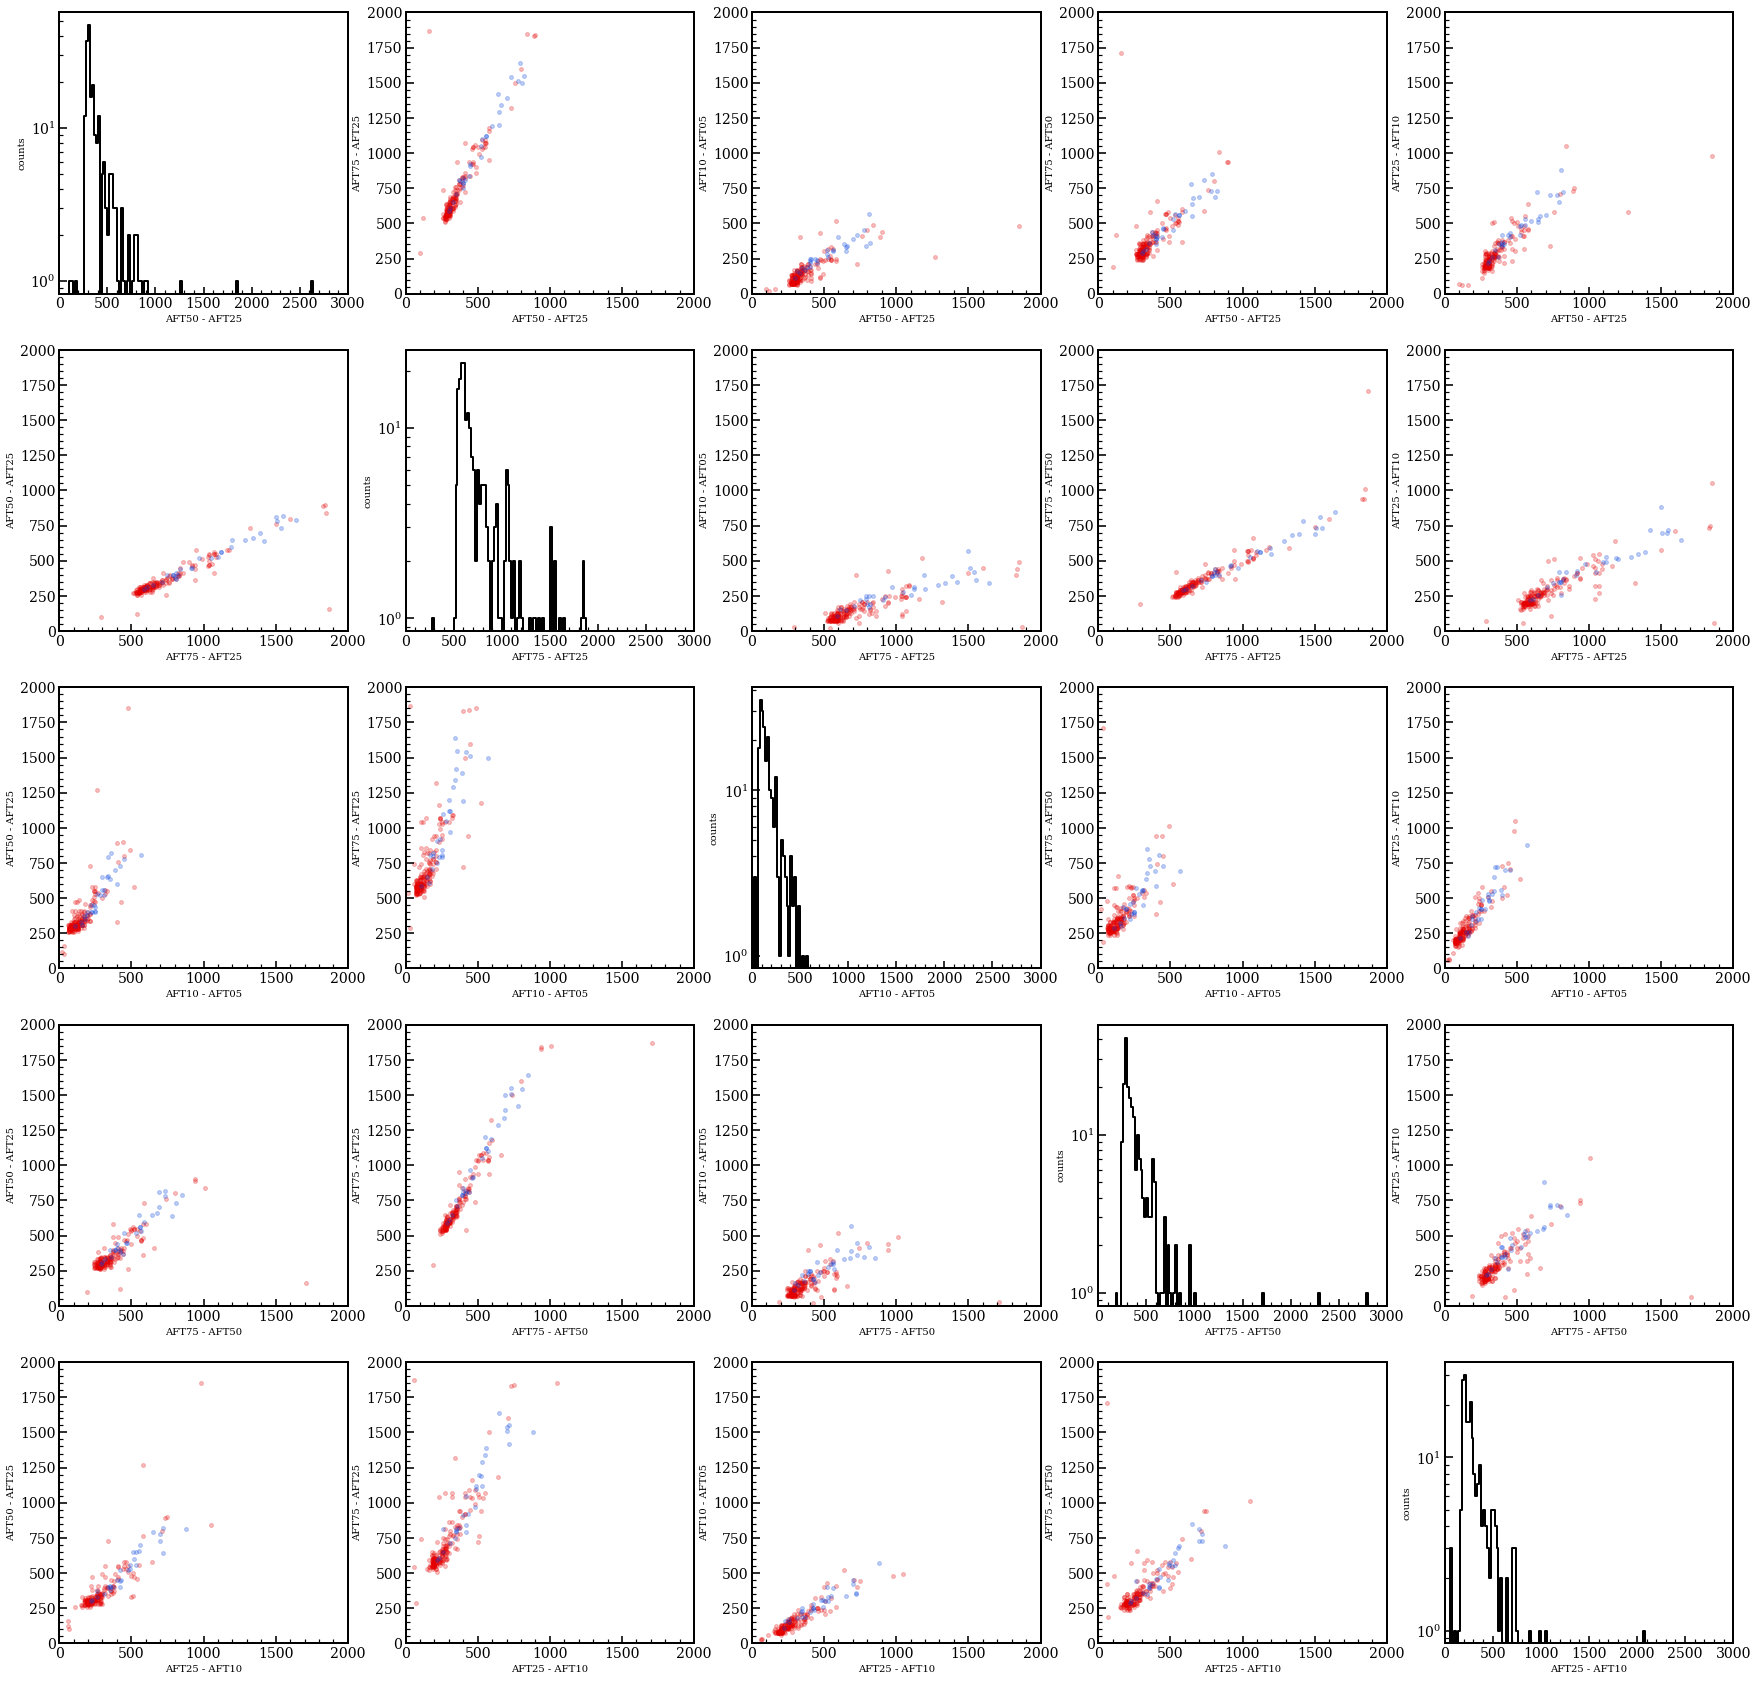

In [11]:
s2_widths = {'AFT50 - AFT25' : s2_width_5025[cuts],
             'AFT75 - AFT25' : s2_width_7525[cuts],
             'AFT10 - AFT05' : s2_width_1005[cuts],
             'AFT75 - AFT50' : s2_width_7550[cuts],
             'AFT25 - AFT10' : s2_width_2510[cuts]}

xbins = np.linspace(0, 5000, num=250, endpoint=False)
ybins = np.linspace(0, 5000, num=250, endpoint=False)

fig, ax = plt.subplots(len(s2_widths), len(s2_widths), figsize=(30, 30))

for i, s2_width_i in enumerate(s2_widths):
    for j, s2_width_j in enumerate(s2_widths):
        if i == j:
            hist, bin_edges = np.histogram(s2_widths[s2_width_i], xbins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            ax[i,j].plot(bin_centers, hist, drawstyle='steps-mid', linewidth=2, color='xkcd:black')
            ax[i,j].set_xlabel(s2_width_i)
            ax[i,j].set_ylabel('counts')
            ax[i,j].tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
            ax[i,j].minorticks_on()
            
            ax[i,j].semilogy()
            ax[i,j].set_xlim([0, 3000])

        else:
            s2_width_i_lowS1 = (s2_widths[s2_width_i])[ s1c[cuts] < 20 ]
            s2_width_i_highS1 = (s2_widths[s2_width_i])[ s1c[cuts] > 20 ]
 
            s2_width_j_lowS1 = (s2_widths[s2_width_j])[ s1c[cuts] < 20 ]
            s2_width_j_highS1 = (s2_widths[s2_width_j])[ s1c[cuts] > 20 ]

            #h, xedges, yedges, im = ax[i,j].hist2d(s2_width_i_lowS1, s2_width_j_lowS1, bins=(xbins, ybins), norm=matplotlib.colors.LogNorm(), cmap='Reds', alpha=0.75)
            #h, xedges, yedges, im = ax[i,j].hist2d(s2_width_i_highS1, s2_width_j_highS1, bins=(xbins, ybins), norm=matplotlib.colors.LogNorm(), cmap='Blues', alpha=0.75)
            ax[i,j].scatter(s2_width_i_lowS1, s2_width_j_lowS1, color='xkcd:red', s=15, alpha=0.25)
            ax[i,j].scatter(s2_width_i_highS1, s2_width_j_highS1, color='xkcd:blue', s=15, alpha=0.25)
            
            ax[i,j].set_xlabel(s2_width_i)
            ax[i,j].set_ylabel(s2_width_j)
            ax[i,j].tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
            ax[i,j].minorticks_on()
            
            ax[i,j].set_xlim([0, 2000])
            ax[i,j].set_ylim([0, 2000])


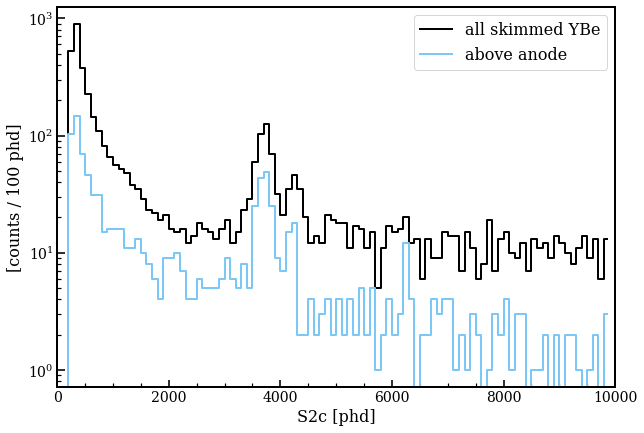

In [12]:
bin_min = 0
bin_max = 10000
num_bins = 100
bins = np.linspace(bin_min, bin_max, num=num_bins, endpoint=False)

S1_TBA_cut = s1_TBA > 0.15
drift_cut = drift_time < 60

s2_hist, bin_edges = np.histogram(s2c, bins)
s2_hist_above_anode, _ = np.histogram(s2c[S1_TBA_cut & drift_cut], bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
binsize = bin_centers[1] - bin_centers[0]

fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
ax.plot(bin_centers, s2_hist, drawstyle='steps-mid', linewidth=2, color='xkcd:black', label='all skimmed YBe')
ax.plot(bin_centers, s2_hist_above_anode, drawstyle='steps-mid', linewidth=2, color='xkcd:lightblue', label='above anode')

ax.set_xlim([0, 10000])
#ax.set_ylim([5e-4, 1e-1])

ax.semilogy()

ax.set_xlabel(r'S2c [phd]', fontsize=16)
ax.set_ylabel('[counts / 100 phd]', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)                                   
ax.minorticks_on()

ax.legend(fontsize=16)

fig.savefig("alpaca_plots/SS_ROI_FV_PW_S2raw_comparison.pdf", bbox_inches='tight')
fig.savefig("alpaca_plots/SS_ROI_FV_PW_S2raw_comparison.png", bbox_inches='tight')

plt.show()


In [13]:
scatters.keys()

['ss.',
 'ss./ss.TObject',
 'ss./ss.TObject/ss.TObject.fUniqueID',
 'ss./ss.TObject/ss.TObject.fBits',
 'ss./ss.nSingleScatters',
 'ss./ss.isDoubleS1',
 'ss./ss.s1PulseID',
 'ss./ss.s1aPulseID',
 'ss./ss.s1bPulseID',
 'ss./ss.s1IsHG',
 'ss./ss.s2PulseID',
 'ss./ss.s2IsHG',
 'ss./ss.driftTime_ns',
 'ss./ss.s1Area_phd',
 'ss./ss.s1aArea_phd',
 'ss./ss.s1bArea_phd',
 'ss./ss.s2Area_phd',
 'ss./ss.s1TopArea_phd',
 'ss./ss.s1aTopArea_phd',
 'ss./ss.s1bTopArea_phd',
 'ss./ss.s1BottomArea_phd',
 'ss./ss.s1aBottomArea_phd',
 'ss./ss.s1bBottomArea_phd',
 'ss./ss.s2TopArea_phd',
 'ss./ss.s2BottomArea_phd',
 'ss./ss.s1TopCorrectionFactor',
 'ss./ss.s1BottomCorrectionFactor',
 'ss./ss.s1CorrectionFactor',
 'ss./ss.correctedS1TopArea_phd',
 'ss./ss.correctedS1aTopArea_phd',
 'ss./ss.correctedS1bTopArea_phd',
 'ss./ss.correctedS1BottomArea_phd',
 'ss./ss.correctedS1aBottomArea_phd',
 'ss./ss.correctedS1bBottomArea_phd',
 'ss./ss.correctedS1Area_phd',
 'ss./ss.correctedS1aArea_phd',
 'ss./ss.correcte

In [14]:
events.keys()

['eventHeader.',
 'eventHeader./eventHeader.TObject',
 'eventHeader./eventHeader.TObject/eventHeader.TObject.fUniqueID',
 'eventHeader./eventHeader.TObject/eventHeader.TObject.fBits',
 'eventHeader./eventHeader.lzapVersion',
 'eventHeader./eventHeader.condVersionTag',
 'eventHeader./eventHeader.condVersionDate',
 'eventHeader./eventHeader.steeringFile',
 'eventHeader./eventHeader.runID',
 'eventHeader./eventHeader.eventID',
 'eventHeader./eventHeader.rawFileName',
 'eventHeader./eventHeader.rawFileDir',
 'eventHeader./eventHeader.triggerTimeStamp_s',
 'eventHeader./eventHeader.triggerTimeStamp_ns',
 'eventHeader./eventHeader.triggerMultiplicity',
 'eventHeader./eventHeader.triggerType',
 'eventHeader./eventHeader.triggerTypePost',
 'eventHeader./eventHeader.triggerHoldOff_ms',
 'eventHeader./eventHeader.preTriggerWindow_ms',
 'eventHeader./eventHeader.postTriggerWindow_ms',
 'eventHeader./eventHeader.sumPodStartTime_s',
 'eventHeader./eventHeader.sumPodStartTime_ns',
 'eventHeader./eve